In [1]:
import sys
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
from torch.distributions.categorical import Categorical

from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
class BasicParameters(nn.Module):
    def __init__(self,
                 data,
                 left_flank=None,
                 right_flank=None,
                 batch_dim=0,
                 cat_axis=-1
                ):
        
        super().__init__()
        
        self.register_parameter('theta', data)
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank)
        
        self.cat_axis = cat_axis
        self.batch_dim = batch_dim
        
    @property
    def shape(self):
        return self().shape

    def forward(self):
        my_attr = [ getattr(self, x) for x in ['theta', 'left_flank', 'right_flank'] ]
        return torch.cat( [ x for x in my_attr if x is not None ], axis=self.cat_axis )
    
    def rebatch(self, input):
        return input


In [3]:
class NUTS3(nn.Module):
    def __init__(self,
                 params,
                 energy_fn,
                ):
        
        super().__init__()
        self.params = params
        self.energy_fn  = energy_fn
        
        self.d_max = 1000.
        
    def calc_energy(self):
        energy = self.energy_fn(self.params())
        energy = self.params.rebatch( energy )
        return energy

    def leapfrog(self, theta, r, epsilon):
        
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
            theta = theta + r.mul(epsilon)
            
        self.params.theta.data = theta
        energy = self.calc_energy()
        grad_U = ag.grad( energy.sum(), self.params.theta )[0]
        
        with torch.no_grad():
            r = r - grad_U.mul(epsilon).div(2.)
            
        return theta, r, energy
        
    def buildtree(self, theta, r, u, v, j, epsilon):
        #print(f'current j: {j}')
        if j == 0:
            theta_p, r_p, energy_p = self.leapfrog(theta, r, v*epsilon)
            batch_dot = torch.einsum('bs,bs->b', r_p.flatten(1), r_p.flatten(1))
            hamilton  = energy_p + batch_dot.div(2.)
            n_p = (u <= torch.exp(-hamilton)).type(torch.long)
            s_p = (torch.log(u).add(-self.d_max) < -hamilton).type(torch.long)
            #print(f'inner j: {j}')
            #print(f'log u: {u.log()}, -H: {-hamilton}')
            #print(theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p, sep='\n')
            return theta_p, r_p, theta_p, r_p, theta_p, n_p, s_p
        
        else:
            #print(f'inner j: {j}')
            bt_pack = self.buildtree(theta, r, u, v, j-1, epsilon)
            theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p = bt_pack
            #[print(a) for a in bt_pack]
            if s_p.sum() > 0:
                if v == -1:
                    bt_pack = self.buildtree(theta_r, r_r, u, v, j-1, epsilon)
                    theta_r, r_r, _, _, theta_pp, n_pp, s_pp = bt_pack
                    
                else:
                    bt_pack = self.buildtree(theta_f, r_f, u, v, j-1, epsilon)
                    _, _, theta_f, r_f, theta_pp, n_pp, s_pp = bt_pack
                
                update_flag = torch.rand(n_pp.size(), dtype=torch.float, 
                                         layout=n_pp.layout, device=n_pp.device)
                update_flag = update_flag < n_pp.div( n_p + n_pp )
                update_flag = torch.logical_and(update_flag, s_p.ge(1) )
                theta_p[ update_flag ] = theta_pp[ update_flag ]
                s_p = s_p * s_pp * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                        .ge(0.).type(torch.long) * \
                      torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                        .ge(0.).type(torch.long)
                n_p = n_p + n_pp
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p)
            return theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p
        
    def init_trajectory(self, theta):
        with torch.no_grad():
            r_0 = torch.randn_like( theta )
            energy_0 = self.calc_energy()
            batch_dot= torch.einsum('bs,bs->b', r_0.flatten(1), r_0.flatten(1))
            hamilton = energy_0 + batch_dot.div(2.)
            u   = torch.rand_like( hamilton ).mul( torch.exp(-hamilton) )
            
            theta_r, theta_f = theta, theta
            r_r, r_f = r_0, r_0
            j = 0
            theta_m = theta
            n = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
            s = torch.ones(batch_dot.size(), dtype=torch.long, layout=batch_dot.layout, device=batch_dot.device)
        return u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s
    
    def sample_trajectory(self, theta, epsilon):
        u, theta_r, r_r, theta_f, r_f, j, theta_m, n, s = self.init_trajectory(theta)
        while s.sum() >= 1:
            v = torch.randn([1], dtype=torch.float, layout=theta.layout, device=theta.device) \
                  .ge(0.).mul(2.).add(-1.)
            if v < 0:
                theta_r, r_r, _, _, theta_p, n_p, s_p = self.buildtree(theta_r, r_r, u, v, j, epsilon)
            else:
                _, _, theta_f, r_f, theta_p, n_p, s_p = self.buildtree(theta_f, r_f, u, v, j, epsilon)
            
            #print('traj results:')
            #print(theta_r, r_r, theta_f, r_f, theta_p, n_p, s_p, sep='\n')
            update_flag = torch.rand_like(n.type(torch.float))
            update_flag = update_flag <= torch.minimum( n / n_p, torch.ones_like(n.type(torch.float)) )
            update_flag = torch.logical_and( update_flag, s.ge(1) )
            update_flag = torch.logical_and( update_flag, s_p.ge(1) )
            #print(f'update_flag: {update_flag}')
            theta_m[ update_flag ] = theta_p[ update_flag ]
            
            n = n + n_p
            s = s * s_p * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_r.flatten(1)) \
                  .ge(0.).type(torch.long) * \
                torch.einsum('bs,bs->b', (theta_f - theta_r).flatten(1), r_f.flatten(1)) \
                  .ge(0.).type(torch.long)
            j = j + 1
        
        return theta_m.detach().clone()
    
    def collect_samples(self, epsilon, n_samples=1):
        samples = []
        theta_m = self.params.theta.clone().detach()
        for m in range(n_samples):
            theta_m = self.sample_trajectory( theta_m, epsilon )
            samples.append( theta_m )
        return samples


In [4]:
def my_energy(in_tensor):
    return in_tensor.pow(2).div(2).sum(dim=(1,2))

def my_rosenbrock(in_tensor):
    hold = in_tensor.mean(dim=2)
    (a-x)^2 + b*(y-x^2)^2
    x = in_tensor[:,0]
    y = in_tensor[:,1]
    
class my_rosenbrock(nn.Module):
    def __init__(self, a=0, b=5):
        super().__init__()
        self.a = a
        self.b = b
        
    def forward(self, in_tensor):
        x = in_tensor[:,0]
        y = in_tensor[:,1]
        
        x = x.flatten(1).sum(dim=1)
        y = y.flatten(1).sum(dim=1)
        
        return (self.a - x).pow(2) + (y - x.pow(2)).mul(self.b).pow(2)
    
def multimodal(in_tensor):
    return torch.add( in_tensor.add(-3).pow(2).div(2).sum(dim=(1,2)).mul(-1).exp(), 
                      in_tensor.add(3).pow(2).div(2).sum(dim=(1,2)).mul(-1).exp() ) \
             .div(2).log().mul(-1.)

In [5]:
checker = torch.randn(4,2,1)
checker

tensor([[[ 0.1706],
         [ 1.1184]],

        [[ 1.9013],
         [-0.4532]],

        [[-1.4587],
         [-0.1627]],

        [[ 0.5327],
         [ 0.5820]]])

In [6]:
my_energy( checker )

tensor([0.6400, 1.9101, 1.0771, 0.3112])

In [7]:
banana = my_rosenbrock()

banana( checker )

tensor([ 29.6948, 417.3458, 133.2878,   2.5074])

In [8]:
multimodal( checker )

tensor([6.4656, 7.2587, 5.9060, 6.6591])

In [9]:
my_params = BasicParameters(
    nn.Parameter(torch.randn([4,2,1])), 
    left_flank=torch.randn([4,2,1])*0.2, 
    right_flank=torch.randn([4,2,1])*0.2
)

my_sampler = NUTS3( my_params, my_energy )

In [10]:
test_theta = torch.randn([4,2,1])
test_r     = torch.randn([4,2,1])
print(test_theta)
print(test_r)
print(my_sampler.params.theta)

tensor([[[ 0.4077],
         [-1.3541]],

        [[-0.6678],
         [ 0.2128]],

        [[ 1.2559],
         [-1.6298]],

        [[-0.6141],
         [ 1.3824]]])
tensor([[[-0.5213],
         [-0.5658]],

        [[ 0.3471],
         [-0.0809]],

        [[-0.3913],
         [-0.8033]],

        [[ 0.9807],
         [-0.4457]]])
Parameter containing:
tensor([[[ 0.2866],
         [ 0.8574]],

        [[ 0.0640],
         [-0.1583]],

        [[-1.2092],
         [-1.1925]],

        [[-0.8020],
         [ 1.7282]]], requires_grad=True)


In [11]:
my_sampler.calc_energy()

tensor([0.4857, 0.0978, 1.5156, 1.9080], grad_fn=<SumBackward1>)

In [12]:
my_sampler.params().pow(2).sum(dim=(1,2))

tensor([0.9714, 0.1957, 3.0312, 3.8160], grad_fn=<SumBackward1>)

In [13]:
torch.einsum('bs,bs->b', test_r.flatten(1),test_r.flatten(1)).div(2.)

tensor([0.2960, 0.0635, 0.3992, 0.5802])

In [14]:
( my_sampler.calc_energy() + torch.einsum('bs,bs->b', test_r.flatten(1),test_r.flatten(1)).div(2.) ).mul(-1.).exp()

tensor([0.4577, 0.8510, 0.1474, 0.0831], grad_fn=<ExpBackward>)

In [15]:
init_vals = my_sampler.init_trajectory(test_theta)
check_u, check_theta_r, check_r_r, check_theta_f, check_r_f, check_j, check_theta_m, check_n, check_s = init_vals
init_vals

(tensor([0.3106, 0.3751, 0.0309, 0.0315]),
 tensor([[[ 0.4077],
          [-1.3541]],
 
         [[-0.6678],
          [ 0.2128]],
 
         [[ 1.2559],
          [-1.6298]],
 
         [[-0.6141],
          [ 1.3824]]]),
 tensor([[[ 1.0856],
          [ 0.2597]],
 
         [[ 0.3133],
          [ 0.8765]],
 
         [[-0.5881],
          [-1.4612]],
 
         [[ 0.8991],
          [-0.8686]]]),
 tensor([[[ 0.4077],
          [-1.3541]],
 
         [[-0.6678],
          [ 0.2128]],
 
         [[ 1.2559],
          [-1.6298]],
 
         [[-0.6141],
          [ 1.3824]]]),
 tensor([[[ 1.0856],
          [ 0.2597]],
 
         [[ 0.3133],
          [ 0.8765]],
 
         [[-0.5881],
          [-1.4612]],
 
         [[ 0.8991],
          [-0.8686]]]),
 0,
 tensor([[[ 0.4077],
          [-1.3541]],
 
         [[-0.6678],
          [ 0.2128]],
 
         [[ 1.2559],
          [-1.6298]],
 
         [[-0.6141],
          [ 1.3824]]]),
 tensor([1, 1, 1, 1]),
 tensor([1, 1, 1, 1]))

In [16]:
v = torch.randn([1], dtype=torch.float, layout=test_theta.layout, device=test_theta.device) \
                  .ge(0.).mul(2.).add(-1.)
v

tensor([-1.])

In [17]:
check_theta_r

tensor([[[ 0.4077],
         [-1.3541]],

        [[-0.6678],
         [ 0.2128]],

        [[ 1.2559],
         [-1.6298]],

        [[-0.6141],
         [ 1.3824]]])

In [18]:
my_sampler.buildtree(check_theta_r, check_r_r, init_vals[0], v, 4, 1e-1)

(tensor([[[-1.0986],
          [-0.2195]],
 
         [[-0.2936],
          [-0.8835]],
 
         [[ 0.5510],
          [ 1.5110]],
 
         [[-0.8814],
          [ 0.8280]]]),
 tensor([[[ 0.3746],
          [-1.3595]],
 
         [[-0.6761],
          [ 0.1863]],
 
         [[ 1.2713],
          [-1.5834]],
 
         [[-0.6399],
          [ 1.4060]]]),
 tensor([[[ 0.2971],
          [-1.3733]],
 
         [[-0.7365],
          [-0.2342]],
 
         [[ 1.3844],
          [-0.7284]],
 
         [[-1.0892],
          [ 1.4785]]]),
 tensor([[[ 1.1208],
          [ 0.1233]],
 
         [[ 0.2451],
          [ 0.8933]],
 
         [[-0.4598],
          [-1.6164]],
 
         [[ 0.8333],
          [-0.7264]]]),
 tensor([[[ 0.2971],
          [-1.3733]],
 
         [[-0.7365],
          [-0.2342]],
 
         [[ 1.3844],
          [-0.7284]],
 
         [[-1.0892],
          [ 1.4785]]]),
 tensor([ 0, 16, 16, 16]),
 tensor([1, 1, 1, 0]))

In [19]:
init_vals = my_sampler.init_trajectory(test_theta)
check_u, check_theta_r, check_r_r, check_theta_f, check_r_f, check_j, check_theta_m, check_n, check_s = init_vals
init_vals

(tensor([0.0580, 0.0139, 0.1130, 0.0434]),
 tensor([[[ 0.4077],
          [-1.3541]],
 
         [[-0.6678],
          [ 0.2128]],
 
         [[ 1.2559],
          [-1.6298]],
 
         [[-0.6141],
          [ 1.3824]]]),
 tensor([[[-1.6567],
          [-0.4728]],
 
         [[ 2.2023],
          [-0.3371]],
 
         [[ 0.5458],
          [ 0.9363]],
 
         [[ 1.9497],
          [-0.6800]]]),
 tensor([[[ 0.4077],
          [-1.3541]],
 
         [[-0.6678],
          [ 0.2128]],
 
         [[ 1.2559],
          [-1.6298]],
 
         [[-0.6141],
          [ 1.3824]]]),
 tensor([[[-1.6567],
          [-0.4728]],
 
         [[ 2.2023],
          [-0.3371]],
 
         [[ 0.5458],
          [ 0.9363]],
 
         [[ 1.9497],
          [-0.6800]]]),
 0,
 tensor([[[ 0.4077],
          [-1.3541]],
 
         [[-0.6678],
          [ 0.2128]],
 
         [[ 1.2559],
          [-1.6298]],
 
         [[-0.6141],
          [ 1.3824]]]),
 tensor([1, 1, 1, 1]),
 tensor([1, 1, 1, 1]))

In [20]:
my_sample = my_sampler.sample_trajectory(check_theta_r, 1e-1)

In [21]:
my_sample

tensor([[[ 2.1818],
         [ 1.0311]],

        [[-0.0366],
         [ 0.2455]],

        [[ 1.1230],
         [-1.2289]],

        [[ 1.1004],
         [-0.5018]]])

In [22]:
my_sampler.params.cuda()

BasicParameters()

In [23]:
start = time.time()
my_samples = my_sampler.collect_samples(1e-1,1000)
print(time.time()-start)

83.93821120262146


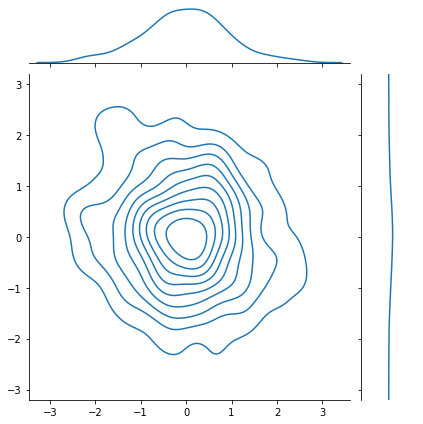

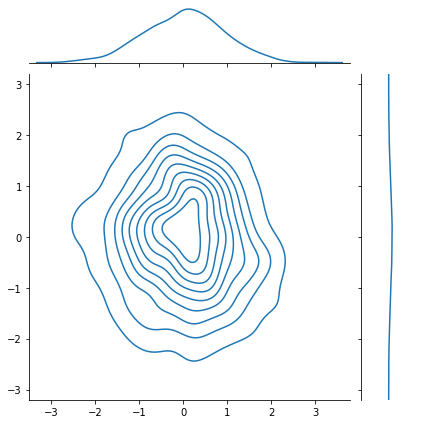

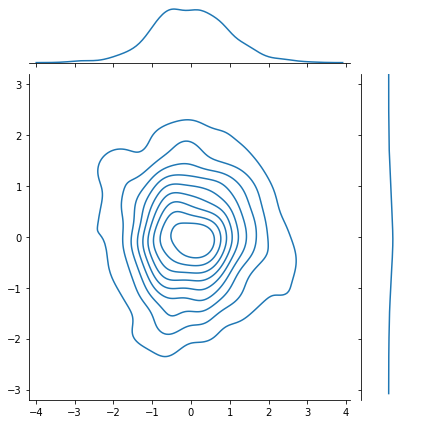

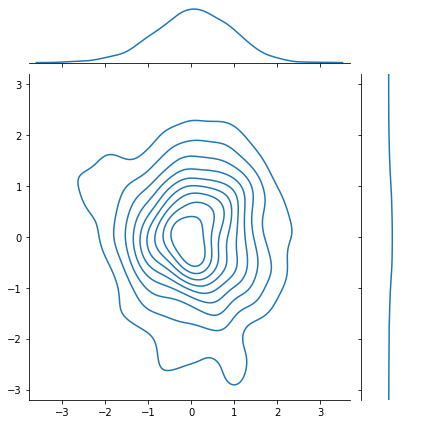

In [24]:
for b_dim in range(check_theta_r.shape[0]):
    g = sns.jointplot(x = torch.cat( my_samples,axis=2 )[b_dim][0].cpu().numpy(), 
                      y = torch.cat( my_samples,axis=2 )[b_dim][1].cpu().numpy(),
                      kind='kde')
    plt.xlim(-3.2, 3.2)
    plt.ylim(-3.2, 3.2)
    plt.show()

In [25]:
my_params.theta.data = torch.randn_like( my_params.theta.data )*0.3

In [26]:
start = time.time()
my_sampler = NUTS3( my_params, banana )
my_samples = my_sampler.collect_samples(1e-2,100)
print(time.time() - start)

61.61717081069946


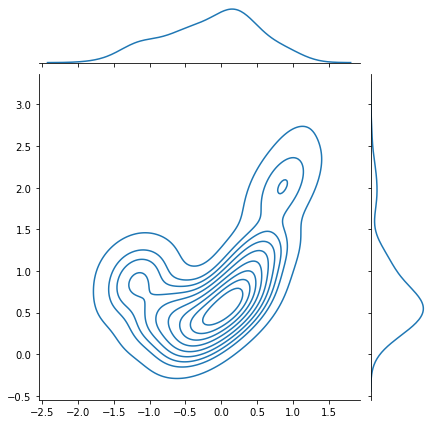

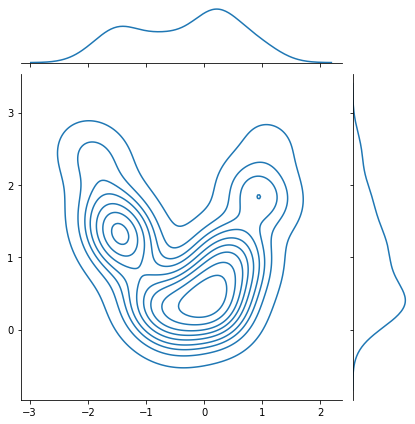

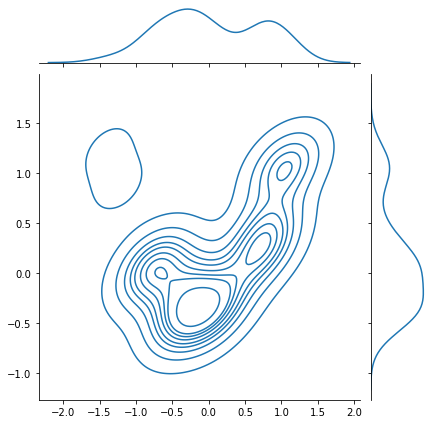

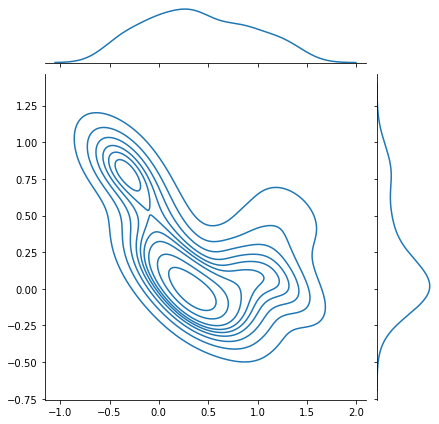

In [27]:
for b_dim in range(check_theta_r.shape[0]):
    g = sns.jointplot(x = torch.cat( my_samples,axis=2 )[b_dim][0].cpu().numpy(), 
                      y = torch.cat( my_samples,axis=2 )[b_dim][1].cpu().numpy(),
                      kind='kde')
    #plt.xlim(-3.2, 3.2)
    #plt.ylim(-3.2, 3.2)
    plt.show()

In [28]:
my_samples[0]

tensor([[[-0.3068],
         [ 0.3357]],

        [[-0.0879],
         [ 0.3436]],

        [[-0.5544],
         [-0.2930]],

        [[ 0.1165],
         [ 0.4071]]], device='cuda:0')

In [29]:
my_params.theta.data = torch.randn_like( my_params.theta.data )*0.3

In [30]:
my_params.cuda()
start = time.time()
my_sampler = NUTS3( my_params, multimodal )
my_samples = my_sampler.collect_samples(1.,2000)
my_params.cpu()
print(time.time() - start)

54.85801124572754


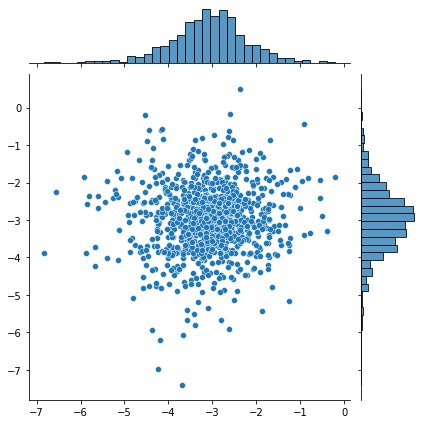

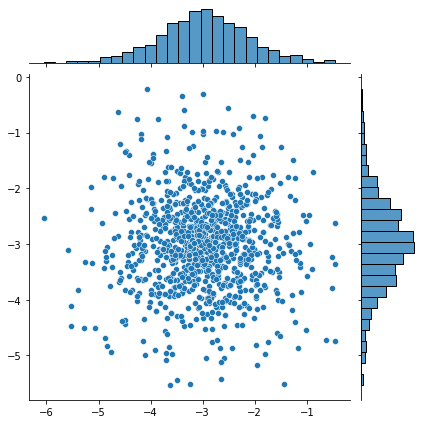

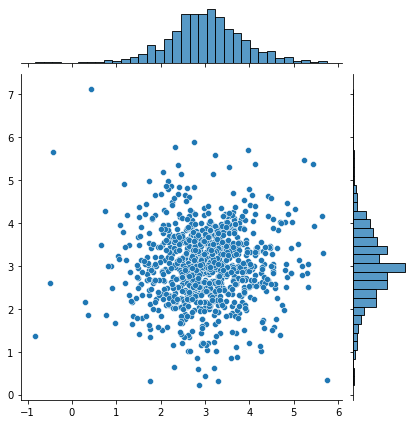

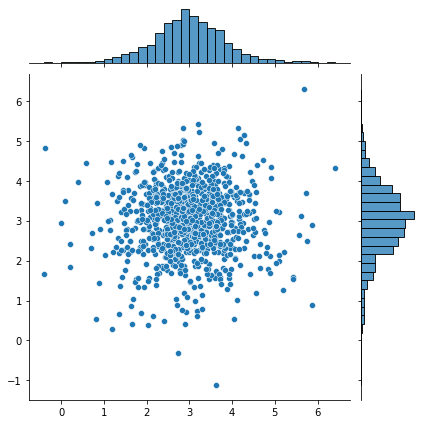

In [31]:
for b_dim in range(check_theta_r.shape[0]):
    g = sns.jointplot(x = torch.cat( my_samples,axis=2 )[b_dim][0][-1000:].cpu().numpy(), 
                      y = torch.cat( my_samples,axis=2 )[b_dim][1][-1000:].cpu().numpy())
    #plt.xlim(-3.2, 3.2)
    #plt.ylim(-3.2, 3.2)
    plt.show()

In [38]:
sobol = torch.quasirandom.SobolEngine(my_params.theta[0].numel(), scramble=True)

In [39]:
hold = sobol.draw(100)

In [40]:
hold

tensor([[0.6955, 0.3038],
        [0.8325, 0.5220],
        [0.2559, 0.1661],
        [0.3999, 0.6849],
        [0.9491, 0.0012],
        [0.5853, 0.7816],
        [0.0057, 0.4026],
        [0.1128, 0.5757],
        [0.5331, 0.2354],
        [0.9349, 0.9536],
        [0.4842, 0.3556],
        [0.3600, 0.8705],
        [0.7834, 0.4445],
        [0.6860, 0.7250],
        [0.2306, 0.0881],
        [0.2119, 0.7036],
        [0.6352, 0.1063],
        [0.7723, 0.8257],
        [0.3167, 0.4863],
        [0.4640, 0.9752],
        [0.8845, 0.3386],
        [0.5205, 0.6208],
        [0.0699, 0.1951],
        [0.0480, 0.7720],
        [0.5974, 0.4169],
        [0.9991, 0.6363],
        [0.4195, 0.0546],
        [0.2998, 0.5319],
        [0.8441, 0.1531],
        [0.7469, 0.9352],
        [0.1702, 0.2518],
        [0.1862, 0.5078],
        [0.7307, 0.1832],
        [0.8599, 0.9013],
        [0.2833, 0.2877],
        [0.4350, 0.7987],
        [0.9843, 0.3884],
        [0.6126, 0.6688],
        [0.0